# PART III: CLASSIFICATION

## 0. GENERAL

- **load module**

In [1]:
# Load nessesary libraries.
import os
import re
import sys
import nltk
import time
import torch
import psutil
import gpustat
import platform
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from datasets import Dataset
from datasets import DatasetDict
from scipy.sparse import hstack
from transformers import Trainer
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import BertForSequenceClassification
from gensim.models import KeyedVectors
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')

- **check computational environment**

In [2]:
# List the software and hardware configurations used for conducting the experiment.
print('WINDOWS VERSION:', platform.platform())
print('PYTHON VERSION:', sys.version)
print('CPU CORE:', psutil.cpu_count(logical=False))
print('CPU SPEED:', psutil.cpu_freq())
print('GPU:', gpustat.new_query().gpus[0].name)
print(f'RAM: {psutil.virtual_memory().total/(1024 ** 3):.2f} GB')
print(f"HARD DRIVE: {psutil.disk_usage('/').total/(1024 ** 3):.2f} GB")

WINDOWS VERSION: Windows-10-10.0.22631-SP0
PYTHON VERSION: 3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
CPU CORE: 4
CPU SPEED: scpufreq(current=2496.0, min=0.0, max=2496.0)
GPU: NVIDIA GeForce GTX 1650
RAM: 31.87 GB
HARD DRIVE: 237.45 GB


- **load dataset**

*experiment dataset*

In [3]:
# Import dataset as pandas data frame.
df_experiment = pd.read_csv('data_jobads_final.csv', index_col=None)

# Apply small modifications.
df_experiment['job_description'] = df_experiment['job_description'].str.replace('\n', ' ')
df_experiment = df_experiment.dropna().reset_index(drop=True)
df_experiment = df_experiment.iloc[:,-2:]

print('The shape of the experiment dataset is:', df_experiment.shape)
df_experiment.head(2)

The shape of the experiment dataset is: (1166, 2)


,job_description,label
0,silver stream healthcare group offer great emp...,registered_nurse
1,create a better future for yourself recruitne...,registered_nurse


*benchmark dataset*

In [4]:
# Import datasets as pandas data frame.
df_benchmark_train = pd.read_csv('ag_news_train.csv', index_col=None)
df_benchmark_test = pd.read_csv('ag_news_test.csv', index_col=None)

In [5]:
print('The shape of the train dataset for benchmark is:', df_benchmark_train.shape)
print('The shape of the test dataset for benchmark is:', df_benchmark_test.shape)
df_benchmark_train.head(2)

The shape of the train dataset for benchmark is: (120000, 2)
The shape of the test dataset for benchmark is: (7600, 2)


,text,label
0,Wall St. Bears Claw Back Into the Black (Reut...,business
1,Carlyle Looks Toward Commercial Aerospace (Re...,business


## 1. CLASSIFICATION WITH FINE-TUNED BERT MODEL

### 1.1 Experimentation

In [6]:
# Starting the timer to track the execution duration.
start = time.time()

*load dataset*

In [7]:
# Create a copy of the original DataFrame for experimentation with BERT.
df_bert = df_experiment.copy()

df_bert.head(2)

,job_description,label
0,silver stream healthcare group offer great emp...,registered_nurse
1,create a better future for yourself recruitne...,registered_nurse


*preprocess dataset*

In [8]:
# Create 'id2label', 'label2id' variables for mapping the labels.
labels = df_experiment['label'].unique().tolist()
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

print(id2label)
print(label2id)

{0: 'registered_nurse', 1: 'electrician', 2: 'data_analyst'}
{'registered_nurse': 0, 'electrician': 1, 'data_analyst': 2}


In [9]:
# Encode the 'label' column.
df_experiment['label_encoded'] = df_experiment.label.map(lambda x: label2id[x.strip()])

df_experiment.head(2)

,job_description,label,label_encoded
0,silver stream healthcare group offer great emp...,registered_nurse,0
1,create a better future for yourself recruitne...,registered_nurse,0


In [10]:
# Examine the distribution and value counts for the 'label_encoded' column.
print('the proportion of total label ID:'.upper())
print(df_experiment['label_encoded'].value_counts(normalize=True).sort_index(), '\n')

print('the count of total label ID:'.upper())
print(df_experiment['label_encoded'].value_counts())

THE PROPORTION OF TOTAL LABEL ID:
0    0.552316
1    0.125214
2    0.322470
Name: label_encoded, dtype: float64 

THE COUNT OF TOTAL LABEL ID:
0    644
2    376
1    146
Name: label_encoded, dtype: int64


*initialize the gpu* (optional)

To enhance the effectiveness of managing matrix and tensor operations, the CUDA device was created. This capability represents a key advantage of utilizing the BERT model within the Torch framework.

In [11]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Check whether CUDA is accessible and, if so, create a CUDA device.
cuda_available = torch.cuda.is_available()
cuda_device= torch.cuda.get_device_name(0)

if cuda_available == True:
    device = torch.device('cuda')
    print('CUDA was successfully installed and compiled on my device.')
    print('CUDA device name is:', cuda_device)
else:
    print('Cuda in not available')

CUDA was successfully installed and compiled on my device.
CUDA device name is: NVIDIA GeForce GTX 1650


*train test split*

In [12]:
def embed_tokens(tokens_list, model):
    vectors = [model[word] for word in tokens_list if word in model]
    if vectors:
        # Averaging the vectors (You could choose another aggregation method)
        embedding = np.mean(vectors, axis=0)
    else:
        # Use a zero vector if none of the tokens were found in the Word2Vec model
        embedding = np.zeros(model.vector_size)
        
    return embedding

In [13]:
# Split the DataFrame into training and testing sets and maintain label proportions.
validation_train, test = train_test_split(df_experiment, test_size=0.3, random_state=630, stratify=df_experiment['label'])
train, validation = train_test_split(validation_train, test_size=0.1, random_state=630, stratify=validation_train['label'])

print('TOTAL shape:', df_experiment.shape)
print('TRAINING shape:', train.shape)
print('VALIDATION shape:', validation.shape)
print('TEST shape:', test.shape)

TOTAL shape: (1166, 3)
TRAINING shape: (734, 3)
VALIDATION shape: (82, 3)
TEST shape: (350, 3)


*convert to Dataset format*

In [14]:
# Convert each set to Dataset format.
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validation)
test_dataset = Dataset.from_pandas(test)

# Remove '__index_level_0__' feature.
train_dataset = train_dataset.remove_columns('__index_level_0__')
val_dataset = val_dataset.remove_columns('__index_level_0__')
test_dataset = test_dataset.remove_columns('__index_level_0__')

# Create DatasetDict variable.
jobads = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test' : test_dataset
    })

*initialize model*

In [15]:
# Load a tokenizer from the 'bert-base-uncased' pretrained model.
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Initialize a BERT-based sequence classification model.
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=3,
                                                      id2label=id2label,
                                                      label2id=label2id)
# Move the model to device.
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

*tokenize text*

In [16]:
# Define a custom tokenization function for processing long and short texts.
def custom_tokenize(batch, strategy='default', max_length=512):
    
    tokenized_outputs = {'input_ids': [], 'attention_mask': []}

    for text in batch['job_description']:
        # Tokenize using the default strategy if the text is shorter than the maximum length.
        if strategy == 'default':
            inputs = tokenizer.encode_plus(text, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
        # Tokenize using the default strategy if the text is longer than the maximum length.
        elif strategy == 'head-tail':
            tokens = tokenizer.tokenize(text)

            head_length = int((max_length - 3) * 0.6)
            tail_length = (max_length - 3) - head_length
            # If the text is longer than the specified maximum length, split it into head and tail parts.
            if len(tokens) > max_length - 2:
                head_tokens = tokens[:head_length]
                tail_tokens = tokens[-tail_length:]
                input_ids = tokenizer.encode_plus(text=' '.join(head_tokens + tail_tokens), max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')['input_ids']
                attention_mask = tokenizer.encode_plus(text=' '.join(head_tokens + tail_tokens), max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')['attention_mask']
            # If the text is within the maximum length, tokenize it as is.
            else:
                encoded_plus = tokenizer.encode_plus(text, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
                input_ids, attention_mask = encoded_plus['input_ids'], encoded_plus['attention_mask']
            inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
        else:

            pass

        # Append tokenized input and attention mask to the outputs.
        tokenized_outputs['input_ids'].append(inputs['input_ids'].squeeze().tolist())
        tokenized_outputs['attention_mask'].append(inputs['attention_mask'].squeeze().tolist())

    return tokenized_outputs

In [17]:
# Define a costum function for tokenization using the 'head-tail' strategy.
def tokenize(examples):
    return custom_tokenize(examples, strategy='head-tail')

In [18]:
# Apply the function to the dataset.
jobads_encoded = jobads.map(tokenize, batched=True, batch_size=None)

print(jobads_encoded)

Map:   0%|          | 0/734 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1220 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/82 [00:00<?, ? examples/s]

Map:   0%|          | 0/350 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['job_description', 'label', 'label_encoded', 'input_ids', 'attention_mask'],
        num_rows: 734
    })
    validation: Dataset({
        features: ['job_description', 'label', 'label_encoded', 'input_ids', 'attention_mask'],
        num_rows: 82
    })
    test: Dataset({
        features: ['job_description', 'label', 'label_encoded', 'input_ids', 'attention_mask'],
        num_rows: 350
    })
})


In [19]:
# Set the dataset format to PyTorch tensors.
jobads_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label_encoded'])

*manage the loss function for inbalanced text*

In [20]:
# Calculate class weights.
labels = train['label_encoded'].unique()
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=labels,
                                     y=train['label_encoded'])

# Convert the computed class weights to a PyTorch tensor.
class_weights = torch.from_numpy(class_weights).float()

print(class_weights)

tensor([2.6594, 1.0367, 0.6026])


In [21]:
# Finalise the dataset.
jobads_encoded = jobads_encoded.rename_column('label_encoded', 'labels')

print(jobads_encoded)

DatasetDict({
    train: Dataset({
        features: ['job_description', 'label', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 734
    })
    validation: Dataset({
        features: ['job_description', 'label', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 82
    })
    test: Dataset({
        features: ['job_description', 'label', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 350
    })
})


In [22]:
# Define the custom trainer class.
class WeightedLossTrainer(Trainer):
    
    # Override the method for loss computation.
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.get('logits')
        labels = inputs.get('labels')
        
        # Move class weights to device.
        class_weights_device = class_weights.to(model.device)
        
        # Calculate the loss using CrossEntropyLoss function with the computed class weights.
        loss_func = nn.CrossEntropyLoss(weight=class_weights_device)
        loss = loss_func(logits, labels)
        
        # Return a tuple containing loss and outputs if 'return_outputs' is True.
        return (loss, outputs) if return_outputs else loss

*manage training argumets*

In [23]:
# Define a costum function to compute accuracy, F1, precision, and recall for a given set of predictions.
def compute_metrics(pred):
  
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  
  return {'Accuracy': acc,
          'F1': f1,
          'Precision': precision,
          'Recall': recall}

In [24]:
# Define the batch size for training.
batch_size = 16

# Calculate the number of logging steps based on the dataset size and batch size.
logging_steps = len(jobads_encoded['train']) // batch_size

# Specify the directory where the trained model and logs will be saved.
output_dir = 'ft_bert_temuulen'

# Create an instance of TrainingArguments to configure the training process.
training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_eval_batch_size=batch_size,
                                  per_gpu_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  logging_steps=logging_steps,
                                  save_strategy='epoch',
                                  fp16=True,
                                  load_best_model_at_end=True)

*fine-tune the model*

In [25]:
# Create an instance of the WeightedLossTrainer for training the model.
trainer = WeightedLossTrainer(model=model,
                              args=training_args,
                              train_dataset=jobads_encoded['train'],
                              eval_dataset=jobads_encoded['validation'],
                              tokenizer=tokenizer,
                              compute_metrics= compute_metrics)

In [26]:
# Start the training.
trainer.train()

  0%|          | 0/276 [00:00<?, ?it/s]

{'loss': 0.4924, 'learning_rate': 1.673913043478261e-05, 'epoch': 0.49}
{'loss': 0.0707, 'learning_rate': 1.3478260869565218e-05, 'epoch': 0.98}


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


  0%|          | 0/6 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'eval_loss': 0.018695557489991188, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 29.7728, 'eval_samples_per_second': 2.754, 'eval_steps_per_second': 0.202, 'epoch': 1.0}
{'loss': 0.01, 'learning_rate': 1.0217391304347829e-05, 'epoch': 1.47}
{'loss': 0.0237, 'learning_rate': 7.028985507246377e-06, 'epoch': 1.96}


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


  0%|          | 0/6 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'eval_loss': 0.003752512624487281, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 30.0971, 'eval_samples_per_second': 2.725, 'eval_steps_per_second': 0.199, 'epoch': 2.0}
{'loss': 0.02, 'learning_rate': 3.768115942028986e-06, 'epoch': 2.45}
{'loss': 0.0041, 'learning_rate': 5.072463768115942e-07, 'epoch': 2.93}


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


  0%|          | 0/6 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'eval_loss': 0.003047032281756401, 'eval_Accuracy': 1.0, 'eval_F1': 1.0, 'eval_Precision': 1.0, 'eval_Recall': 1.0, 'eval_runtime': 28.8592, 'eval_samples_per_second': 2.841, 'eval_steps_per_second': 0.208, 'epoch': 3.0}
{'train_runtime': 2534.305, 'train_samples_per_second': 0.869, 'train_steps_per_second': 0.109, 'train_loss': 0.10129850775516336, 'epoch': 3.0}


TrainOutput(global_step=276, training_loss=0.10129850775516336, metrics={'train_runtime': 2534.305, 'train_samples_per_second': 0.869, 'train_steps_per_second': 0.109, 'train_loss': 0.10129850775516336, 'epoch': 3.0})

*save model*

In [27]:
# Save the fine-tuned BERT model.
trainer.model.save_pretrained('ft_bert_temuulen2')

# Save the tokenizer used for fine-tuning to the 'ft_bert_temuulen3_tokenizer'.
tokenizer.save_pretrained('ft_bert_temuulen_tokenizer2')

torch.cuda.empty_cache()

*evaluate model*

In [28]:
# Specify the directory paths for the fine-tuned model and tokenizer.
model_path = 'ft_bert_temuulen2'
tokenizer_path = 'ft_bert_temuulen_tokenizer2'

# Load the BERT and the tokenizer.
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

In [29]:
# Load prepared an unseen dataset.
test_dataset = jobads_encoded['test'] 

# Create a Trainer instance.
classifier = Trainer(model=model, tokenizer=tokenizer)
predictions = classifier.predict(test_dataset)

# Convert predictions to numpy for further analysis.
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)

  0%|          | 0/44 [00:00<?, ?it/s]

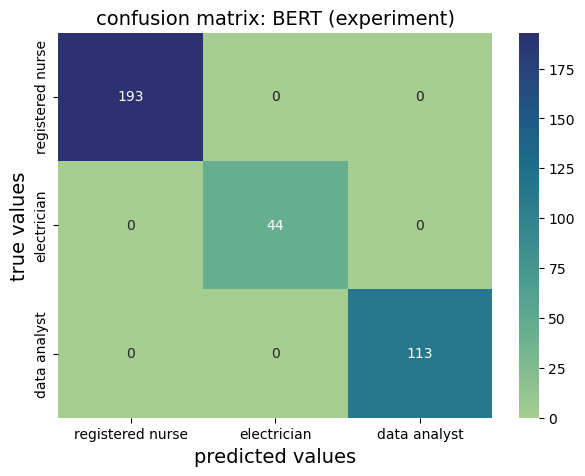

CLASSIFICATION REPORT: fine-tuned 'bert-base-uncased' model for classification 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       193
           1       1.00      1.00      1.00        44
           2       1.00      1.00      1.00       113

    accuracy                           1.00       350
   macro avg       1.00      1.00      1.00       350
weighted avg       1.00      1.00      1.00       350

{'registered_nurse': 0, 'electrician': 1, 'data_analyst': 2}


In [30]:
# Plot Confusion Matrix.
cm_labels = ['registered nurse', 'electrician', 'data analyst']
cm_matrix = confusion_matrix(labels, preds)
cm_title = 'confusion matrix: BERT (experiment)'

plt.figure(figsize=(7, 5))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='crest', xticklabels=cm_labels, yticklabels=cm_labels)

plt.title(cm_title, fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.ylabel('true values', fontsize=14)

plt.show()

# Print detailed classification report.
report = classification_report(labels, preds, output_dict=True)
report_title = "CLASSIFICATION REPORT: fine-tuned 'bert-base-uncased' model for classification"

print(report_title, '\n')
print(classification_report(labels, preds))
print(label2id)

In [31]:
torch.cuda.empty_cache()
end = time.time()
print(f'The calculation of classification experimentation with fine-tuning Bert model completed in: : {int((end - start)) // 60} minutes and {int((end - start)) % 60} seconds.')

The calculation of classification experimentation with fine-tuning Bert model completed in: : 1 minutes and 41 seconds.


### 1.2 Test

In [32]:
# Initialize a text classification pipeline.
classifier = pipeline('text-classification', model='ft_bert_temuulen2', tokenizer='ft_bert_temuulen_tokenizer2')

In [33]:
# Test model with random text samples.
random_text = ["1. I promote health and help people who is sick", 
               "2. If your outlet isn't working and you don't have a light, you can ask me to fix it.", 
               "3. All day, I'm sitting in front of the screen, solving problems with my mouse and keyboard", 
               "4. I'm familiar with the process of providing injections to individuals.",
               "5. If the streetlights fail, I can replace them with new ones.",
               "6. I'm familiar with both Python and R, and I use these tools for my work."]

for x in range(len(random_text)):
    print(classifier(random_text[x]), '=', random_text[x])

[{'label': 'registered_nurse', 'score': 0.9787058234214783}] = 1. I promote health and help people who is sick
[{'label': 'data_analyst', 'score': 0.48012831807136536}] = 2. If your outlet isn't working and you don't have a light, you can ask me to fix it.
[{'label': 'data_analyst', 'score': 0.8985043168067932}] = 3. All day, I'm sitting in front of the screen, solving problems with my mouse and keyboard
[{'label': 'registered_nurse', 'score': 0.8870661854743958}] = 4. I'm familiar with the process of providing injections to individuals.
[{'label': 'electrician', 'score': 0.638813316822052}] = 5. If the streetlights fail, I can replace them with new ones.
[{'label': 'data_analyst', 'score': 0.9607547521591187}] = 6. I'm familiar with both Python and R, and I use these tools for my work.


The random sentences employed to evaluate the fine-tuned Bert-base classification model were intentionally vague and concise, aiming to assess the model's capability in challenging scenarios. Nevertheless, the outcomes and associated scores demonstrate that the model excelled, accurately forecasting every sentence with significant confidence levels (average probability score: **0.8041**).

In [34]:
# Test model with job seekers' data.
# Load the experiment participants dataset.
df_jobseeker = pd.read_csv('data_jobseeker.csv', index_col=None)

# Apply minor modifications for further use.
df_jobseeker['combined_info'] = df_jobseeker.education + '. ' + df_jobseeker.skill + '. ' + df_jobseeker.experience + '.'
df_jobseeker.drop(['education', 'skill', 'experience'], axis=1, inplace=True)

for x in range(3):
    print(classifier(df_jobseeker.iat[x, -1]), '=', df_jobseeker.iat[x, -2])

[{'label': 'registered_nurse', 'score': 0.9984044432640076}] = registered nurse
[{'label': 'electrician', 'score': 0.9907193779945374}] = electrician
[{'label': 'data_analyst', 'score': 0.9932025671005249}] = data analyst


All data from each participant in the experiment was classified and assigned into the appropriate labelled classes with outstanding results.(average probability score: **0.9926**)

### 1.3 Benchmarking

In [35]:
# Starting the timer to track the execution duration.
start = time.time()

*load dataset*

In [36]:
df_benchmark_train_bert = df_benchmark_train.copy()
df_benchmark_test_bert = df_benchmark_test.copy()

*preprocess dataset*

In [37]:
labels = df_benchmark_train_bert['label'].unique().tolist()
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

print(id2label)
print(label2id)

{0: 'business', 1: 'sci/tech', 2: 'sports', 3: 'world'}
{'business': 0, 'sci/tech': 1, 'sports': 2, 'world': 3}


In [38]:
# Encode the 'label' column.
df_benchmark_train_bert['label_encoded'] = df_benchmark_train_bert.label.map(lambda x: label2id[x.strip()])
df_benchmark_test_bert['label_encoded'] = df_benchmark_test_bert.label.map(lambda x: label2id[x.strip()])

In [39]:
# Examine the distribution and value counts for the 'label_encoded' column.
print('the proportion of total label ID in a train dataset:'.upper())
print(df_benchmark_train_bert['label_encoded'].value_counts(normalize=True).sort_index(), '\n')

print('the count of total label ID in a train dataset:'.upper())
print(df_benchmark_train_bert['label_encoded'].value_counts())

THE PROPORTION OF TOTAL LABEL ID IN A TRAIN DATASET:
0    0.25
1    0.25
2    0.25
3    0.25
Name: label_encoded, dtype: float64 

THE COUNT OF TOTAL LABEL ID IN A TRAIN DATASET:
0    30000
1    30000
2    30000
3    30000
Name: label_encoded, dtype: int64


In [40]:
# Examine the distribution and value counts for the 'label_encoded' column.
print('the proportion of total label ID in a test dataset:'.upper())
print(df_benchmark_test_bert['label_encoded'].value_counts(normalize=True).sort_index(), '\n')

print('the count of total label ID in a test dataset:'.upper())
print(df_benchmark_test_bert['label_encoded'].value_counts())

THE PROPORTION OF TOTAL LABEL ID IN A TEST DATASET:
0    0.25
1    0.25
2    0.25
3    0.25
Name: label_encoded, dtype: float64 

THE COUNT OF TOTAL LABEL ID IN A TEST DATASET:
0    1900
1    1900
2    1900
3    1900
Name: label_encoded, dtype: int64


*train test split*

In [41]:
df_bert_drop, df_bert_use_train = train_test_split(df_benchmark_train_bert, 
                                                   test_size=0.01, random_state=630, 
                                                   stratify=df_benchmark_train_bert['label'])

df_bert_drop, df_bert_use_test = train_test_split(df_benchmark_test_bert, 
                                                   test_size=0.06, random_state=630, 
                                                   stratify=df_benchmark_test_bert['label'])

In [42]:
# Split the DataFrame into training and testing sets and maintain label proportions.
train, validation = train_test_split(df_bert_use_train, test_size=0.3, random_state=630)
test = df_bert_use_test.copy()
print('TRAINING shape:', train.shape)
print('VALIDATION shape:', validation.shape)
print('TEST shape:', test.shape)

TRAINING shape: (840, 3)
VALIDATION shape: (360, 3)
TEST shape: (456, 3)


*convert to Dataset format*

In [43]:
# Convert each set to Dataset format.
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validation)
test_dataset = Dataset.from_pandas(test)

# Remove '__index_level_0__' feature.
train_dataset = train_dataset.remove_columns('__index_level_0__')
val_dataset = val_dataset.remove_columns('__index_level_0__')

# Create DatasetDict variable.
benchmark_text = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test' : test_dataset
    })

In [44]:
# Load a tokenizer from the 'bert-base-uncased' pretrained model.
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Initialize a BERT-based sequence classification model.
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=4,
                                                      id2label=id2label,
                                                      label2id=label2id)
# Move the model to device.
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [46]:
# Define a custom tokenization function for long and short text.
def custom_tokenize(batch, strategy='default', max_length=512):
    
    tokenized_outputs = {'input_ids': [], 'attention_mask': []}

    for text in batch['text']:
        # Tokenize using the default strategy if the text is shorter than the maximum length.
        if strategy == 'default':
            inputs = tokenizer.encode_plus(text, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
        # Tokenize using the default strategy if the text is longer than the maximum length.
        elif strategy == 'head-tail':
            tokens = tokenizer.tokenize(text)

            head_length = int((max_length - 3) * 0.6)
            tail_length = (max_length - 3) - head_length
            # If the text is longer than the specified maximum length, split it into head and tail parts.
            if len(tokens) > max_length - 2:
                head_tokens = tokens[:head_length]
                tail_tokens = tokens[-tail_length:]
                input_ids = tokenizer.encode_plus(text=' '.join(head_tokens + tail_tokens), max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')['input_ids']
                attention_mask = tokenizer.encode_plus(text=' '.join(head_tokens + tail_tokens), max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')['attention_mask']
            # If the text is within the maximum length, tokenize it as is.
            else:
                encoded_plus = tokenizer.encode_plus(text, max_length=max_length, truncation=True, padding='max_length', return_tensors='pt')
                input_ids, attention_mask = encoded_plus['input_ids'], encoded_plus['attention_mask']
            inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}
        else:

            pass

        # Append tokenized input and attention mask to the outputs.
        tokenized_outputs['input_ids'].append(inputs['input_ids'].squeeze().tolist())
        tokenized_outputs['attention_mask'].append(inputs['attention_mask'].squeeze().tolist())

    return tokenized_outputs

In [47]:
# Apply the function to the dataset.
benchmark_text_encoded = benchmark_text.map(tokenize, batched=True, batch_size=None)

print(benchmark_text_encoded)

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Map:   0%|          | 0/456 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_encoded', 'input_ids', 'attention_mask'],
        num_rows: 840
    })
    validation: Dataset({
        features: ['text', 'label', 'label_encoded', 'input_ids', 'attention_mask'],
        num_rows: 360
    })
    test: Dataset({
        features: ['text', 'label', 'label_encoded', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 456
    })
})


In [48]:
# Set the dataset format to PyTorch tensors.
benchmark_text_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label_encoded'])

*manage the loss function for inbalanced text*

In [49]:
# Calculate class weights.
labels = train['label_encoded'].unique()
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=labels,
                                     y=train['label_encoded'])

# Convert the computed class weights to a PyTorch tensor.
class_weights = torch.from_numpy(class_weights).float()

print(class_weights)

tensor([0.9589, 1.0000, 1.0345, 1.0096])


In [50]:
# Finalise the dataset.
benchmark_text_encoded = benchmark_text_encoded.rename_column('label_encoded', 'labels')

print(benchmark_text_encoded)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 840
    })
    validation: Dataset({
        features: ['text', 'label', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 360
    })
    test: Dataset({
        features: ['text', 'label', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 456
    })
})


In [51]:
# Define the custom trainer class.
class WeightedLossTrainer(Trainer):
    
    # Override the method for loss computation.
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.get('logits')
        labels = inputs.get('labels')
        
        # Move class weights to device.
        class_weights_device = class_weights.to(model.device)
        
        # Calculate the loss using CrossEntropyLoss function with the computed class weights.
        loss_func = nn.CrossEntropyLoss(weight=class_weights_device)
        loss = loss_func(logits, labels)
        
        # Return a tuple containing loss and outputs if 'return_outputs' is True.
        return (loss, outputs) if return_outputs else loss

In [52]:
# Define the batch size for training.
batch_size = 16

# Calculate the number of logging steps based on the dataset size and batch size.
logging_steps = len(benchmark_text_encoded['train']) // batch_size

# Specify the directory where the trained model and logs will be saved.
output_dir = 'ft_bert_temuulen_benchmark'

# Create an instance of TrainingArguments to configure the training process.
training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_eval_batch_size=batch_size,
                                  per_gpu_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  logging_steps=logging_steps,
                                  save_strategy='epoch',
                                  fp16=True,
                                  load_best_model_at_end=True)

In [53]:
# Create an instance of the WeightedLossTrainer for training the model.
trainer = WeightedLossTrainer(model=model,
                              args=training_args,
                              train_dataset=benchmark_text_encoded['train'],
                              eval_dataset=benchmark_text_encoded['validation'],
                              tokenizer=tokenizer,
                              compute_metrics= compute_metrics)

In [53]:
# Start the training.
trainer.train()

  0%|          | 0/315 [00:00<?, ?it/s]

{'loss': 1.176, 'learning_rate': 1.6825396825396828e-05, 'epoch': 0.5}
{'loss': 0.5947, 'learning_rate': 1.3523809523809525e-05, 'epoch': 0.99}


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


  0%|          | 0/23 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'eval_loss': 0.4301092326641083, 'eval_Accuracy': 0.8805555555555555, 'eval_F1': 0.879026233303989, 'eval_Precision': 0.8836533140605471, 'eval_Recall': 0.8778349132039555, 'eval_runtime': 123.1293, 'eval_samples_per_second': 2.924, 'eval_steps_per_second': 0.187, 'epoch': 1.0}
{'loss': 0.3283, 'learning_rate': 1.0222222222222223e-05, 'epoch': 1.49}
{'loss': 0.23, 'learning_rate': 6.920634920634921e-06, 'epoch': 1.98}


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


  0%|          | 0/23 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'eval_loss': 0.3995382487773895, 'eval_Accuracy': 0.8944444444444445, 'eval_F1': 0.8941220292073973, 'eval_Precision': 0.8963201251861046, 'eval_Recall': 0.8934674701595365, 'eval_runtime': 123.1772, 'eval_samples_per_second': 2.923, 'eval_steps_per_second': 0.187, 'epoch': 2.0}
{'loss': 0.1379, 'learning_rate': 3.6190476190476194e-06, 'epoch': 2.48}
{'loss': 0.174, 'learning_rate': 3.174603174603175e-07, 'epoch': 2.97}


Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.
Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


  0%|          | 0/23 [00:00<?, ?it/s]

Using deprecated `--per_gpu_eval_batch_size` argument which will be removed in a future version. Using `--per_device_eval_batch_size` is preferred.


{'eval_loss': 0.3919348120689392, 'eval_Accuracy': 0.8972222222222223, 'eval_F1': 0.8972324602625437, 'eval_Precision': 0.8998947287804846, 'eval_Recall': 0.8960447897471654, 'eval_runtime': 122.6064, 'eval_samples_per_second': 2.936, 'eval_steps_per_second': 0.188, 'epoch': 3.0}
{'train_runtime': 3307.3645, 'train_samples_per_second': 0.762, 'train_steps_per_second': 0.095, 'train_loss': 0.4379071776829069, 'epoch': 3.0}


TrainOutput(global_step=315, training_loss=0.4379071776829069, metrics={'train_runtime': 3307.3645, 'train_samples_per_second': 0.762, 'train_steps_per_second': 0.095, 'train_loss': 0.4379071776829069, 'epoch': 3.0})

*save model*

In [54]:
# Save the fine-tuned BERT model.
trainer.model.save_pretrained('ft_bert_temuulen2_benchmark')

# Save the tokenizer used for fine-tuning to the 'ft_bert_temuulen3_tokenizer'.
tokenizer.save_pretrained('ft_bert_temuulen_tokenizer2_benchmark')

torch.cuda.empty_cache()

*evaluate model*

In [55]:
# Specify the directory paths for the fine-tuned model and tokenizer.
model_path = 'ft_bert_temuulen2_benchmark'
tokenizer_path = 'ft_bert_temuulen_tokenizer2_benchmark'

# Load the BERT and the tokenizer.
model = BertForSequenceClassification.from_pretrained(model_path, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [57]:
# Load prepared an unseen dataset.
test_dataset = benchmark_text_encoded['test'] 

# Create a Trainer instance.
classifier = Trainer(model=model, tokenizer=tokenizer)
predictions = classifier.predict(test_dataset)

# Convert predictions to numpy for further analysis.
labels = predictions.label_ids
preds = predictions.predictions.argmax(-1)

  0%|          | 0/57 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Plot Confusion Matrix.
cm_labels = np.unique(np.concatenate((labels, preds)))
cm_matrix = confusion_matrix(labels, preds)
cm_title = 'confusion matrix: BERT(benchmark)'

plt.figure(figsize=(7, 5))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='crest', xticklabels=cm_labels, yticklabels=cm_labels)

plt.title(cm_title, fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.ylabel('true values', fontsize=14)

plt.show()

# Print detailed classification report.
report = classification_report(labels, preds, output_dict=True)
report_title = 'classification report: BERT(benchmark)'

print(report_title, '\n')
print(classification_report(labels, preds))
print(label2id)

In [58]:
torch.cuda.empty_cache()
end = time.time()
print(f'The calculation of classification benchmarking with fine-tuning Bert model completed in: : {int((end - start)) // 60} minutes and {int((end - start)) % 60} seconds.')

The calculation of classification benchmarking with fine-tuning Bert model completed in: : 25 minutes and 32 seconds.


## 2. CLASSIFICATION WITH PRE-TRAINED WORD2VEC MODEL

### 2.1 Experimenttion

In [ ]:
# Starting the timer to track the execution duration.
start = time.time()

*load dataset*

In [ ]:
# Create a copy of the original DataFrame for experimentation with BERT.
df_words2vec = df_experiment.copy()

df_words2vec.head(2)

*initialize tools*

In [ ]:
# Load the pre-trained Word2Vec model.
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# Initialize the Logistic Regression model (original approach)
clf = LogisticRegression(max_iter=1000, class_weight='balanced')  # Increased max_iter for convergence

*preprocess and tokenize dataset*

In [ ]:
# Create 'id2label', 'label2id' variables for mapping the labels.
labels = df_words2vec['label'].unique().tolist()
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

print(id2label)
print(label2id)

In [ ]:
# Encode the 'label' column.
df_words2vec['label_encoded'] = df_words2vec.label.map(lambda x: label2id[x.strip()])

df_words2vec.head(2)

In [ ]:
# Lowercasing and tokenizing
def preprocess_text_word2vec(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    
    return tokens

In [ ]:
df_words2vec['processed_jd'] = df_words2vec['job_description'].apply(preprocess_text_word2vec)

df_words2vec.head(2)

*embed text*

In [ ]:
def embed_tokens(tokens_list, model):
    vectors = [model[word] for word in tokens_list if word in model]
    if vectors:
        # Averaging the vectors (You could choose another aggregation method)
        embedding = np.mean(vectors, axis=0)
    else:
        # Use a zero vector if none of the tokens were found in the Word2Vec model
        embedding = np.zeros(model.vector_size)
        
    return embedding

In [ ]:
# Apply the function to embed each row's tokens in the DataFrame
df_words2vec['vectors'] = df_words2vec['processed_jd'].apply(lambda x: embed_tokens(x, word2vec))
# This will add a new column 'word2vec_embedding' where each row contains the aggregated Word2Vec embedding for its tokens

print('The shape of the first tensor:', df_words2vec.iat[0, -1].shape, '\n')
print('The shape of the second tensor:', df_words2vec.iat[1, -1].shape, '\n')
print(df_words2vec.iat[0, -1], '\n')

df_words2vec.head(2)

*train test split*

In [ ]:
X = np.stack(df_words2vec['vectors'].values)  # Convert the list of vectors into a numpy array
y = df_words2vec['label_encoded'].values      # Get the target values

In [ ]:
# Splitting dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=630)
print('TRAINING shape:', X_train.shape)
print('TEST shape:', X_test.shape)

*train model*

In [ ]:
# Fit the model on the training data
clf.fit(X_train, y_train)

*evaluate model*

In [ ]:
# Making predictions.
preds = clf.predict(X_test)
labels = y_test

In [ ]:
print('classification report: LOGISTIC REGRESSION (WORD2VEC)\n\n', classification_report(labels, preds))

cm_labels = ['registered nurse', 'electrician', 'data analyst']
cm_matrix = confusion_matrix(labels, preds)
cm_title = 'confusion matrix: LOGISTIC REGRESSION (WORD2VEC)'


plt.figure(figsize=(7, 5))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='crest', xticklabels=cm_labels, yticklabels=cm_labels)

plt.title(cm_title, fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.ylabel('true values', fontsize=14)

plt.show()

print(id2label)

In [ ]:
end = time.time()
print(f'The calculation of classification experimentation with pre-trained Word2Vec model completed in: : {int((end - start)) // 60} minutes and {int((end - start)) % 60} seconds.')

### 2.2 Benchmarking

In [ ]:
# Starting the timer to track the execution duration.
start = time.time()

*load dataset*

In [ ]:
df_benc_train_word2vec = df_benchmark_train.copy()
df_benc_test_word2vec = df_benchmark_test.copy()

*preprocess and tokenize dataset*

In [ ]:
# Check the 'label' column for unique values.
labels = df_benc_train_word2vec['label'].unique().tolist()
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

print(id2label)
print(label2id)

In [ ]:
# Encode the 'label' column.
df_benc_train_word2vec['label_encoded'] = df_benc_train_word2vec.label.map(lambda x: label2id[x.strip()])
df_benc_test_word2vec['label_encoded'] = df_benc_test_word2vec.label.map(lambda x: label2id[x.strip()])

df_benchmark_test.head(2)

In [ ]:
df_benc_train_word2vec['processed_text'] = df_benc_train_word2vec['text'].apply(preprocess_text_word2vec)
df_benc_test_word2vec['processed_text'] = df_benc_test_word2vec['text'].apply(preprocess_text_word2vec)

df_benc_test_word2vec.head(2)

*embed text*

In [ ]:
df_benc_train_word2vec['vectors'] = df_benc_train_word2vec['processed_text'].apply(lambda x: embed_tokens(x, word2vec))
df_benc_test_word2vec['vectors'] = df_benc_test_word2vec['processed_text'].apply(lambda x: embed_tokens(x, word2vec))

df_benc_train_word2vec.head(2)

*train test split*

In [ ]:
drop_df, df_word2vec_use_train = train_test_split(df_benc_train_word2vec, 
                                                   test_size=0.01, random_state=630, 
                                                   stratify=df_benc_train_word2vec['label'])

drop_df, df_word2vec_use_test = train_test_split(df_benc_test_word2vec, 
                                                   test_size=0.06, random_state=630, 
                                                   stratify=df_benc_test_word2vec['label'])

In [ ]:
# Split the DataFrame into training and testing sets and maintain label proportions.
train, drop_val = train_test_split(df_word2vec_use_train, test_size=0.3, random_state=630)
test = df_word2vec_use_test.copy()
print('TRAINING shape:', train.shape)
print('TEST shape:', test.shape)

In [ ]:
X_train = np.stack(train['vectors'].values)
X_test = np.stack(test['vectors'].values)
y_train = train['label_encoded'].copy()
y_test = test['label_encoded'].copy()
print('TRAINING shape:', X_train.shape)
print('TEST shape:', X_test.shape)

*train model*

In [ ]:
# Fit the model on the training data
clf.fit(X_train, y_train)

*evaluate model*

In [ ]:
# You can now use log_reg to make predictions and evaluate the model
preds = clf.predict(X_test)
labels = y_test

print('classification report: LOGISTIC REGRESSION (PRETRAINED WORD2WEC)\n\n', classification_report(labels, preds))

cm_labels = np.unique(np.concatenate((labels, preds)))
cm_matrix = confusion_matrix(labels, preds)
cm_title = 'confusion matrix: LOGISTIC REGRESSION (PRETRAINED WORD2WEC)'


plt.figure(figsize=(7, 5))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='crest', xticklabels=cm_labels, yticklabels=cm_labels)

plt.title(cm_title, fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.ylabel('true values', fontsize=14)

plt.show()

print(id2label)

In [ ]:
end = time.time()
print(f'The calculation of classification benchmarking with pre-trained Word2Vec model completed in: : {int((end - start)) // 60} minutes and {int((end - start)) % 60} seconds.')

## 3. CLASSIFICATION WITH TF-IDF AND BOW

### 3.1 Experimentation

In [ ]:
# Starting the timer to track the execution duration.
start = time.time()

*load dataset*

In [ ]:
# Create a copy of the original DataFrame for experimentation with BERT.
df_tfidf = df_experiment.copy()

df_tfidf.head(2)

*load tools*

In [ ]:
# Download necessary NLTK data.
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

*preprocess and tokenize dataset*

In [ ]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stopwords and lemmatization
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Re-joining tokens
    processed_text = ' '.join(processed_tokens)
    return processed_text

In [ ]:
# Create 'id2label', 'label2id' variables for mapping the labels.
labels = df_tfidf['label'].unique().tolist()
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

print(id2label)
print(label2id)

In [ ]:
# Encode the 'label' column.
df_tfidf['label_encoded'] = df_tfidf.label.map(lambda x: label2id[x.strip()])

df_tfidf.head(2)

In [ ]:
df_tfidf['processed_jd'] = df_tfidf['job_description'].apply(preprocess_text)

df_tfidf.head(2)

*train test split*

In [ ]:
# Splitting dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(df_tfidf['processed_jd'], df_tfidf['label_encoded'], test_size=0.3, random_state=630)
print('TOTAL shape:', df_tfidf.shape)
print('TRAINING shape:', X_train.shape)
print('TEST shape:', X_test.shape)

*embed text*

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
bow_vectorizer = CountVectorizer()
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [ ]:
X_train_combined = hstack([X_train_bow, X_train_tfidf])
X_test_combined = hstack([X_test_bow, X_test_tfidf])

*train model*

In [ ]:
# Training the model with combined features
clf.fit(X_train_combined, y_train)

*evaluate model*

In [ ]:
# Making predictions
preds = clf.predict(X_test_combined)
labels = y_test

In [ ]:
print('classification report: LOGISTIC REGRESSION (TF-IDF + BOW)\n\n', classification_report(labels, preds))

cm_labels = ['registered nurse', 'electrician', 'data analyst']
cm_matrix = confusion_matrix(labels, preds)
cm_title = 'confusion matrix: LOGISTIC REGRESSION (TF-IDF + BOW)'


plt.figure(figsize=(7, 5))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='crest', xticklabels=cm_labels, yticklabels=cm_labels)

plt.title(cm_title, fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.ylabel('true values', fontsize=14)

plt.show()

print(id2label)

In [ ]:
end = time.time()
print(f'The calculation of classification experimentation with TF-IDF and BoW completed in: : {int((end - start)) // 60} minutes and {int((end - start)) % 60} seconds.')

### 3.2 Benchmarking

In [ ]:
# Starting the timer to track the execution duration.
start = time.time()

*load dataset*

In [ ]:
df_benc_train_tfidf = df_benchmark_train.copy()
df_benc_test_tfidf = df_benchmark_test.copy()

*preprocess and tokenize dataset*

In [ ]:
# Check the 'label' column for unique values.
labels = df_benc_train_tfidf['label'].unique().tolist()
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

print(id2label)
print(label2id)

In [ ]:
# Encode the 'label' column.
df_benc_train_tfidf['label_encoded'] = df_benc_train_tfidf.label.map(lambda x: label2id[x.strip()])
df_benc_test_tfidf['label_encoded'] = df_benc_test_tfidf.label.map(lambda x: label2id[x.strip()])

df_benc_test_tfidf.head(2)

In [ ]:
df_benc_train_tfidf['processed_text'] = df_benc_train_tfidf['text'].apply(preprocess_text)
df_benc_test_tfidf['processed_text'] = df_benc_test_tfidf['text'].apply(preprocess_text)

df_benc_test_tfidf.head(2)

*train test split*

In [ ]:
drop_df, df_tfidf_use_train = train_test_split(df_benc_train_tfidf, 
                                                   test_size=0.01, random_state=630, 
                                                   stratify=df_benc_train_tfidf['label'])

drop_df, df_tfidf_use_test = train_test_split(df_benc_test_tfidf, 
                                                   test_size=0.06, random_state=630, 
                                                   stratify=df_benc_test_tfidf['label'])

In [ ]:
# Split the DataFrame into training and testing sets and maintain label proportions.
train, drop_val = train_test_split(df_tfidf_use_train, test_size=0.3, random_state=630)
test = df_tfidf_use_test.copy()
print('TRAINING shape:', train.shape)
print('TEST shape:', test.shape)

In [ ]:
X_train = df_tfidf_use_train['processed_text'].copy()
X_test = df_tfidf_use_test['processed_text'].copy()
y_train = df_tfidf_use_train['label_encoded'].copy()
y_test = df_tfidf_use_test['label_encoded'].copy()
print('TRAINING shape:', X_train.shape)
print('TEST shape:', X_test.shape)

*embed text*

In [ ]:
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

In [ ]:
X_train_combined = hstack([X_train_bow, X_train_tfidf])
X_test_combined = hstack([X_test_bow, X_test_tfidf])

*train model*

In [ ]:
# Training the model with combined features
clf.fit(X_train_combined, y_train)

*evaluate model*

In [ ]:
# Making predictions
preds = clf.predict(X_test_combined)
labels = y_test

In [ ]:
print('classification report: LOGISTIC REGRESSION (TF-IDF + BOW)\n\n', classification_report(labels, preds))

cm_labels = np.unique(np.concatenate((labels, preds)))
cm_matrix = confusion_matrix(labels, preds)
cm_title = 'confusion matrix: LOGISTIC REGRESSION (TF-IDF + BOW)'


plt.figure(figsize=(7, 5))
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='crest', xticklabels=cm_labels, yticklabels=cm_labels)

plt.title(cm_title, fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.ylabel('true values', fontsize=14)

plt.show()

print(id2label)

In [ ]:
end = time.time()
print(f'The calculation of classification benchmarking with with TF-IDF and BoW completed in: : {int((end - start)) // 60} minutes and {int((end - start)) % 60} seconds.')